In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mutual_info_score
from scipy.special import kl_div
from functools import reduce
import glob
from tqdm import tqdm
tqdm.pandas()
import warnings
from datasets import load_dataset
import os
from scipy.stats import entropy

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [9]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

In [10]:
reward_files = glob.glob('/users/lucelo/UQLRM/metadata_single_mlp_*.tsv')

In [11]:
def compute_unc_ce_corr(reward_files):
    reward_dfs = []
    for file in reward_files:
        df = pd.read_csv(file, sep='\t', header=0)[['id', 'RewardScore', 'Dataset', 'Preference']]
        chosen_df = df[df['Preference'] == 'chosen'].rename(columns={'RewardScore': 'RewardChosen'})
        rejected_df = df[df['Preference'] == 'rejected'].rename(columns={'RewardScore': 'RewardRejected'})
        merged_df = chosen_df.merge(rejected_df, on=['id', 'Dataset'], how='inner')
        merged_df['RewardDiff'] = merged_df['RewardChosen'] - merged_df['RewardRejected']
        merged_df['PreferenceProb'] = sigmoid(merged_df['RewardDiff'])
        reward_dfs.append(merged_df)
    
    for i, df in enumerate(reward_dfs):
        # Add unique suffixes to the column names
        df.columns = [f"{col}_{i}" if col != 'id' else col for col in df.columns]
    
    final_rewards =  pd.concat(reward_dfs, axis=1)
    final_rewards['PrefProbVariance'] = final_rewards.filter(like="PreferenceProb", axis=1).var(axis=1)
    final_rewards['PrefProbAverage'] = final_rewards.filter(like="PreferenceProb", axis=1).mean(axis=1)
    final_rewards['Error'] = (final_rewards['PrefProbAverage'] < 0.5) * 1.0
    final_rewards['GT'] = 1.0
    final_rewards['CrossEntropy'] = kl_div(final_rewards['GT'], final_rewards['PrefProbAverage'])

    dataset_column = "Dataset_0"
    train_df = final_rewards[final_rewards[dataset_column] == 'train']
    test_df = final_rewards[final_rewards[dataset_column] == 'test']
    eval_df = final_rewards[final_rewards[dataset_column] == 'eval']
    ood_df = final_rewards[final_rewards[dataset_column] == 'ood']

    train_corr = train_df['PrefProbVariance'].corr(train_df['CrossEntropy'], method='spearman')
    test_corr = test_df['PrefProbVariance'].corr(test_df['CrossEntropy'], method='spearman')
    eval_corr = eval_df['PrefProbVariance'].corr(eval_df['CrossEntropy'], method='spearman')
    ood_corr = ood_df['PrefProbVariance'].corr(ood_df['CrossEntropy'], method='spearman')

    return train_corr, test_corr, eval_corr, ood_corr

Text(0.5, 1.0, 'Uncertainty-CrossEntropy vs Ensemble Size')

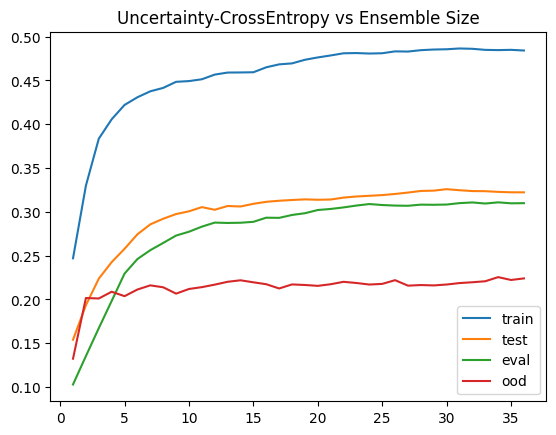

In [18]:
train_corrs = []
eval_corrs = []
test_corrs = []
ood_corrs = []
for i in range(len(reward_files)):
    chosen_files = reward_files[:i + 1]
    train_corr, test_corr, eval_corr, ood_corr = compute_unc_ce_corr(chosen_files)
    train_corrs.append(train_corr)
    test_corrs.append(test_corr)
    eval_corrs.append(eval_corr)
    ood_corrs.append(ood_corr)

plt.plot(train_corrs, label='train')
plt.plot(test_corrs, label='test')
plt.plot(eval_corrs, label='eval')
plt.plot(ood_corrs, label='ood')
plt.legend()
plt.title('Uncertainty-CrossEntropy vs Ensemble Size')